In [1]:
import uproot 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import scipy.integrate as integrate
import scipy.stats as ss

from scipy.optimize import curve_fit 
from scipy.special import erf

In [2]:
# Define the range for the fit and the plot (lower and upper mass range)
m_l, m_u = 5.36688-0.02, 5.36688+0.02   # Adjusted range with ±0.02 around 5.36688
# m_l, m_u = 5.36688-0.01, 5.36688+0.01
# m_l, m_u = 5.36688-0.015, 5.36688+0.015

print(f"From {m_l:.5f} to {m_u:.5f} GeV")

From 5.34688 to 5.38688 GeV


In [3]:
# Define the folder path 
# FOLDER_NAME = './preselect_mPhi/'
FOLDER_NAME = './preselect_q2/'

# Define file paths for each dataset type
FILE_NAME_DT = {
    "sig.": FOLDER_NAME + "ee2Z2Bs2PhiMuMu_preselect.root",
    "bb":   FOLDER_NAME + "ee2Z2b_comb_cutted_preselect.root",
    "cc":   FOLDER_NAME + "ee2Z2c_comb_cutted_preselect.root",
}

# Load ROOT files and convert them into DataFrames
FILE_DT = {key: uproot.open(path) for key, path in FILE_NAME_DT.items()}
DF_DT = {
    key: pd.DataFrame(np.array(FILE_DT[key]['t'].arrays()))
    for key in FILE_DT
}

# Define yields for each dataset type
YIELD_DT = {
    "sig.": 6.33e4,
    "bb":   1.24e7,
    "cc":   3.13e5,
}


### Functions for signal and background distibutions

In [4]:
# Gaussian function
def Gauss(x, a, x0, sigma):
    return a * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

# Normalized Gaussian function
def Gauss_norm(x, a, x0, sigma):
    pdf = np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))
    return a * pdf / np.sum(pdf)

# Double Gaussian function
def Gauss2(x, a1, x0, sigma1, a2, sigma2):
    g1 = a1 * np.exp(-(x - x0) ** 2 / (2 * sigma1 ** 2))
    g2 = a2 * np.exp(-(x - x0) ** 2 / (2 * sigma2 ** 2))
    return g1 + g2

# Double Crystal Ball function
def DoubleCB(x, A, x0, sigma, alphaL, nL, alphaR, nR):
    # Calculate constants for left and right tails
    AL = (nL / abs(alphaL)) ** nL * np.exp(-0.5 * abs(alphaL) ** 2)
    AR = (nR / abs(alphaR)) ** nR * np.exp(-0.5 * abs(alphaR) ** 2)
    BL = nL / abs(alphaL) - abs(alphaL)
    BR = nR / abs(alphaR) - abs(alphaR)

    # Create masks for left, right, and central regions
    maskL = (x - x0) / sigma < -alphaL
    maskR = (x - x0) / sigma > alphaR

    # Compute PDF for left, right, and central regions
    pdfL = AL * (BL - (x[maskL] - x0) / sigma) ** (-nL)
    pdfR = AR * (BR + (x[maskR] - x0) / sigma) ** (-nR)
    pdfM = np.exp(-0.5 * ((x - x0) / sigma) ** 2)

    # Combine regions into a single PDF
    pdf = pdfM
    pdf[maskL] = pdfL
    pdf[maskR] = pdfR

    return A * pdf

# Exponential function
def Expo(x, a, c):
    return a * np.exp(-c * x)


### Signal Fit


In [5]:
# Define the range for the mBs variable
range_mBs = [5.36688 - 0.04, 5.36688 + 0.04]  # ±0.04 around 5.36688

# Extract and filter the mBs values from the DataFrame
mBs_values = DF_DT['sig.']['mBs'].copy()  # Copy relevant data
filtered_mBs = mBs_values[(mBs_values > range_mBs[0]) & (mBs_values < range_mBs[1])]  # Apply range filter

# Calculate histogram weights based on the signal yield
weights = YIELD_DT['sig.'] / len(DF_DT['sig.']['mBs'])  # Weight per entry
weights_array = np.full(len(filtered_mBs), weights)  # Create an array of weights

# Define histogram parameters
num_bins = 50  # Number of bins for the histogram
factor = 100   # Scaling factor for bin heights (if needed)

# Create a weighted histogram
bin_heights, bin_borders = np.histogram(
    filtered_mBs,
    bins=num_bins,
    range=range_mBs,
    weights=weights_array
)

# Calculate the centers of the histogram bins (useful for plotting or fitting)
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2


In [6]:
# Generate x-values for fitting (higher resolution for smooth curve)
x_interval_for_fit_sig = np.linspace(*range_mBs, num_bins * factor)

# Fit the Double Crystal Ball (DCB) function to the histogram data
# Initial parameters for the fit: [amplitude, mean, std, alphaL, nL, alphaR, nR]
initial_params = [
    max(bin_heights),          # Initial guess for amplitude
    filtered_mBs.mean(),       # Mean of the filtered data
    filtered_mBs.std(),        # Standard deviation of the filtered data
    1,                         # Initial guess for alphaL
    1,                         # Initial guess for nL
    1,                         # Initial guess for alphaR
    1                          # Initial guess for nR
]
poptdcb, pcov_dcb = curve_fit(DoubleCB, bin_centers, bin_heights, p0=initial_params)

# Define x-values for the fitted function
x_fit = np.linspace(range_mBs[0], range_mBs[1], num_bins * factor)

# Calculate the y-values of the fitted Double Crystal Ball function
y_dcb = DoubleCB(x_fit, *poptdcb)

# Scale the amplitude to account for normalization
scale_factor = (
    (YIELD_DT['sig.'] * len(filtered_mBs) / len(DF_DT['sig.']))  # Ratio of effective yields
    / (np.sum(y_dcb) / factor)                                  # Normalize to histogram scale
)
poptdcb[0] *= scale_factor  # Adjust amplitude parameter

# Recalculate y-values after scaling
y_dcb = DoubleCB(x_fit, *poptdcb)


Check point (DCB):
Number of events from the fit:			 6.32e+04
Number of events from the yield estimate:	 6.33e+04


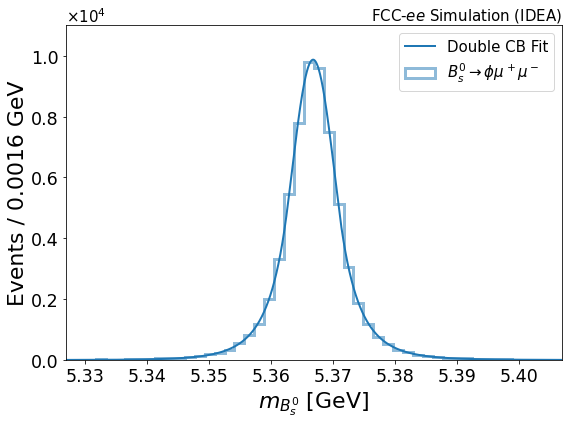

In [7]:
# Create a figure and axis for the plot
f, ax = plt.subplots(figsize=(8, 6))

# Define label for the Double CB fit curve
label2 = 'Double CB Fit'

# Plot the Double CB fit curve
ax.plot(
    x_interval_for_fit_sig, y_dcb, 
    label=label2, color='C0', lw=2
)

# Plot the histogram of mBs values
ax.hist(
    DF_DT['sig.']['mBs'], bins=num_bins, range=range_mBs,
    weights=np.full(len(mBs_values), weights),  # Apply weights
    lw=3, histtype='step', alpha=0.5,
    label=r'$B_s^0\to\phi\mu^+\mu^-$'
)

# Format y-axis ticks to include a scaling factor
locs = ax.get_yticks()
ax.set_yticks(locs, map(lambda x: "%.1f" % (x * 1e-4), locs))
ax.text(
    0, 1.01, r'$\times 10^4$', fontsize=15,
    transform=ax.transAxes
)

# Set y-axis limits and remove x-axis margins
ax.set_ylim(0, 1.1e4)
ax.margins(x=0)

# Calculate bin width and set axis labels
bin_width_s = (range_mBs[1] - range_mBs[0]) / num_bins
ax.set_ylabel(f"Events / {bin_width_s:.4f} GeV", fontsize=22)
ax.set_xlabel(r"$m_{B_s^0}$ [GeV]", fontsize=22)
ax.tick_params(axis='both', which='major', labelsize=17.5)

# Add title or annotation for context
ax.text(
    1, 1.03, r'FCC-$ee$ Simulation (IDEA)',
    horizontalalignment='right', verticalalignment='center',
    transform=ax.transAxes, fontsize=15
)

# Show the legend
ax.legend(fontsize=15)

# Print a summary of the fit results
print("Check point (DCB):\n"
      f"Number of events from the fit:\t\t\t {np.sum(y_dcb) / factor:.2e}\n"
      f"Number of events from the yield estimate:\t {YIELD_DT['sig.']:.2e}")

# Save the figure and display the plot
plt.tight_layout()
f.savefig("mBsFit_sig.pdf")
plt.show()


### bb Bkg. fit

In [20]:
# Define the range for mBs values
range_b = [4, 6]

# Extract mBs values from the DataFrame and filter based on the range
X_b = DF_DT['bb']['mBs'].copy()
X_b = X_b[(X_b > range_b[0]) & (X_b < range_b[1])]

# Set the number of bins and scaling factor for weights
bins_ = 50
fac_ = 1000

# Calculate weights for the histogram
# Each entry's weight is the yield divided by the total number of entries
w_b_h = np.full(len(DF_DT['bb']['mBs']), YIELD_DT['bb'] / len(DF_DT['bb']['mBs']))

# Compute histogram of mBs values with weights
bin_heights, bin_borders = np.histogram(
    DF_DT['bb']['mBs'], bins=bins_, range=range_b, weights=w_b_h
)

# Calculate bin centers for plotting
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2

bin_width_b = (range_b[1] - range_b[0])/bins_

In [21]:
poptexp, pcov = curve_fit(Expo, bin_centers, bin_heights, p0=[max(bin_heights), 1/max(bin_heights)])

x_interval_for_fit_b = np.linspace(range_b[0], range_b[-1], bins_*fac_)
y_exp = Expo(x_interval_for_fit_b, *poptexp)

poptexp[0] *= (YIELD_DT['bb'] * len(X_b) / len(DF_DT['bb'])) / (np.sum(y_exp) / fac_)
y_exp = Expo(x_interval_for_fit_b, *poptexp)

Checkpoint: 
Number of events from the fit: 			7.25e+05
Number of events from the yield estimate: 	7.25e+05


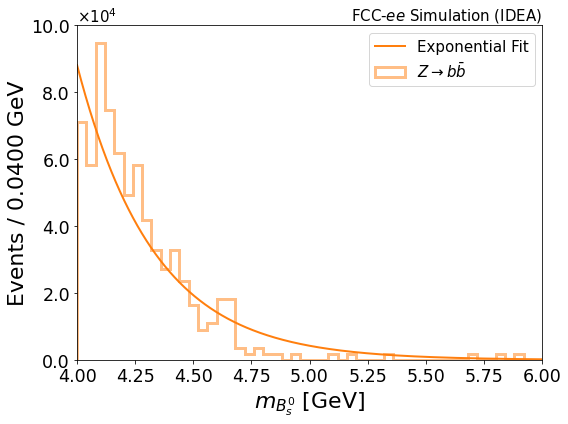

In [22]:
# Plot configuration
fig, ax = plt.subplots(figsize=(8, 6))

# Exponential fit label
label_fit = 'Exponential Fit'

# Plot the exponential fit curve
ax.plot(x_interval_for_fit_b, y_exp, label=label_fit, color='C1', lw=2)

# Plot the histogram of mBs values
ax.hist(
    X_b, range=range_b, bins=bins_,
    color='C1', lw=3, histtype='step', alpha=0.5,
    weights=w_b_h[:len(X_b)],
    label=r'$Z \to b\bar{b}$'
)

# Customize y-axis ticks and scaling
locs = ax.get_yticks()
ax.set_yticks(locs, map(lambda x: f"{x * 1e-4:.1f}", locs))
ax.text(0.0, 1.01, r'$\times 10^4$', fontsize=15, transform=ax.transAxes)

# Set axis labels and appearance
bin_width = (range_b[1] - range_b[0]) / bins_
ax.set_ylabel(f"Events / {bin_width:.4f} GeV", fontsize=22)
ax.set_xlabel(r"$m_{B_s^0}$ [GeV]", fontsize=22)
ax.tick_params(axis='both', which='major', labelsize=17.5)

# Add text annotation for simulation details
ax.text(
    1, 1.03, r'FCC-$ee$ Simulation (IDEA)',
    horizontalalignment='right',
    verticalalignment='center',
    transform=ax.transAxes,
    fontsize=15
)

# Add legend
ax.legend(fontsize=15)

# Adjust plot margins
ax.margins(x=0)

# Print event counts for verification
print(
    "Checkpoint: \n"
    f"Number of events from the fit: \t\t\t{sum(y_exp) / fac_:.2e}\n"
    f"Number of events from the yield estimate: \t"
    f"{YIELD_DT['bb'] * len(X_b) / len(DF_DT['bb']['mBs']):.2e}"
)

# Display the plot
plt.tight_layout()
plt.show()



### cc Bkg. fit

In [23]:
# Define the range for the mass distribution
range_c = [2, 6]

# Copy and filter 'mBs' values for the 'cc' category within the specified range
X_c = DF_DT['cc']['mBs'].copy()
X_c = X_c[(X_c > range_c[0]) & (X_c < range_c[1])]

# Set histogram parameters
bins_ = 50  # Number of bins
fac_ = 100  # Scaling factor for the results (if needed)

# Calculate weights for histogram based on yield estimate
w_c_h = np.full(len(DF_DT['cc']['mBs']), YIELD_DT['cc'] / len(DF_DT['cc']['mBs']))


# Create histogram to calculate heights and borders
bin_heights, bin_borders = np.histogram(
    DF_DT['cc']['mBs'], bins=bins_, range=range_c, weights=w_c_h
)

# Calculate the centers of the bins
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2

bin_width_c = (range_c[1] - range_c[0])/bins_

In [24]:
poptexp_c, pcov_c = curve_fit(Expo, bin_centers, bin_heights, p0=[max(bin_heights), 1/max(bin_heights)])

x_interval_for_fit_c = np.linspace(range_c[0], range_c[-1], bins_*fac_)
y_exp_c = Expo(x_interval_for_fit_c, *poptexp_c)

poptexp_c[0] *= (YIELD_DT['cc'] * len(X_c) / len(DF_DT['cc'])) / (np.sum(y_exp_c) / fac_)
y_exp_c = Expo(x_interval_for_fit_c, *poptexp_c)

Checkpoint: 
Number of events from the fit: 			1.31e+05
Number of events from the yield estimate: 	1.31e+05


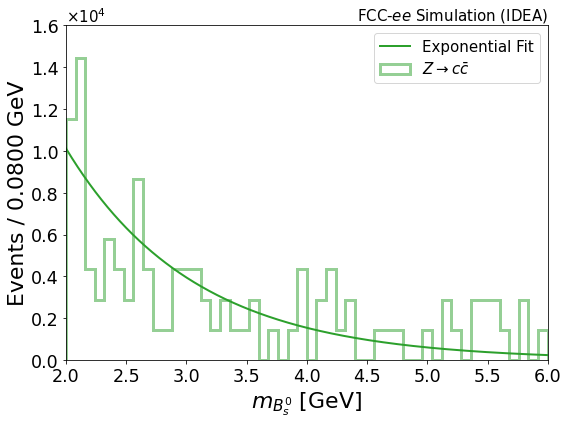

In [25]:
# Plot configuration
fig, ax = plt.subplots(figsize=(8, 6))

# Exponential fit label
label_fit = 'Exponential Fit'

# Plot the exponential fit curve
ax.plot(x_interval_for_fit_c, y_exp_c, label=label_fit, color='C2', lw=2)

# Plot the histogram of mBs values
ax.hist(
    X_c, range=range_c, bins=bins_,
    color='C2', lw=3, histtype='step', alpha=0.5,
    weights=w_c_h[:len(X_c)],
    label=r'$Z \to c\bar{c}$'
)

# Customize y-axis ticks and scaling
locs = ax.get_yticks()
ax.set_yticks(locs, map(lambda x: f"{x * 1e-4:.1f}", locs))
ax.text(0.0, 1.01, r'$\times 10^4$', fontsize=15, transform=ax.transAxes)

# Set axis labels and appearance
bin_width = (range_c[1] - range_c[0]) / bins_
ax.set_ylabel(f"Events / {bin_width:.4f} GeV", fontsize=22)
ax.set_xlabel(r"$m_{B_s^0}$ [GeV]", fontsize=22)
ax.tick_params(axis='both', which='major', labelsize=17.5)

# Add text annotation for simulation details
ax.text(
    1, 1.03, r'FCC-$ee$ Simulation (IDEA)',
    horizontalalignment='right',
    verticalalignment='center',
    transform=ax.transAxes,
    fontsize=15
)

# Add legend
ax.legend(fontsize=15)

# Adjust plot margins
ax.margins(x=0)

# Print event counts for verification
print(
    "Checkpoint: \n"
    f"Number of events from the fit: \t\t\t{sum(y_exp_c) / fac_:.2e}\n"
    f"Number of events from the yield estimate: \t"
    f"{YIELD_DT['cc'] * len(X_c) / len(DF_DT['cc']['mBs']):.2e}"
)

# Display the plot
plt.tight_layout()
plt.show()


### Combined Plot

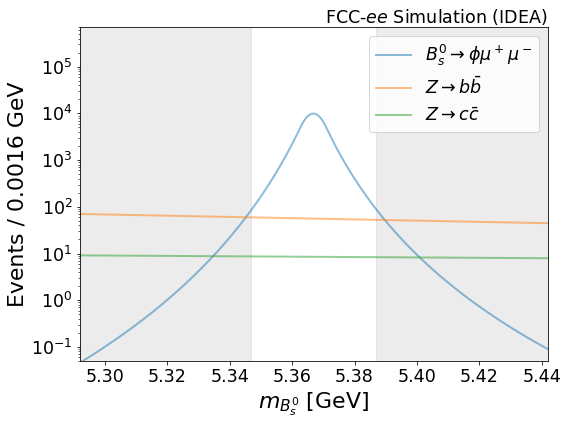

In [26]:
# Create the plot figure and axis
f, ax = plt.subplots(1, figsize=(8, 6))

# Define the range for plotting
range_plot = [5.36688 - 0.075, 5.36688 + 0.075]

# Create x-values for the plot (interval)
x_interval_for_plot = np.linspace(range_plot[0], range_plot[1], bins_ * fac_)

# Calculate the fitted curves
y_exp_plot = Expo(x_interval_for_plot, *poptexp) / bin_width_b * bin_width_s
y_exp_c_plot = Expo(x_interval_for_plot, *poptexp_c) / bin_width_c * bin_width_s
y_dcb_plot = DoubleCB(x_interval_for_plot, *poptdcb)

# Plot the functions
ax.plot(x_interval_for_plot, y_dcb_plot, label=r'$B_s^0\to \phi\mu^+\mu^-$', color='C0', lw=2, alpha=0.5)
ax.plot(x_interval_for_plot, y_exp_plot, label=r'$Z\to b\bar{b}$', color='C1', lw=2, alpha=0.5)
ax.plot(x_interval_for_plot, y_exp_c_plot, label=r'$Z\to c\bar{c}$', color='C2', lw=2, alpha=0.5)

# Set axis labels and formatting
ax.set_xlabel(r"$m_{B_s^0}$ [GeV]", fontsize=22)
ax.set_ylabel(rf"Events / {bin_width_s:.4f} GeV", fontsize=22)
ax.tick_params(axis='both', which='major', labelsize=17.5)

# Add the simulation text label
ax.text(1, 1.03, r'FCC-$ee$ Simulation (IDEA)', horizontalalignment='right',
        verticalalignment='center', transform=ax.transAxes, fontsize=17.5)

# Display the legend
ax.legend(fontsize=17.5, loc=1)

# Highlight the signal region with shaded areas
ax.axvspan(range_plot[0], m_l, alpha=0.15, color='grey')
ax.axvspan(m_u, range_plot[1], alpha=0.15, color='grey')

# Set logarithmic scale for y-axis
ax.set_yscale('log')

# Set axis limits
ax.set_xlim(*range_plot)
ax.set_ylim(0.5e-1, 0.7e6)

# Adjust layout and save the plot
plt.tight_layout()
f.savefig("mBs.pdf")

# Show the plot
plt.show()


In [27]:
# ==============================================================================================

# Calculate efficiencies for signal, background, and mass window
in_range_s = len(filtered_mBs) / len(DF_DT['sig.'])
in_mass_window_s = np.sum(y_dcb[(x_interval_for_fit_sig > m_l) & (x_interval_for_fit_sig < m_u)]) / np.sum(y_dcb)

in_range_b = len(X_b) / len(DF_DT['bb'])
in_mass_window_b = np.sum(y_exp[(x_interval_for_fit_b > m_l) & (x_interval_for_fit_b < m_u)]) / np.sum(y_exp)

in_range_c = len(X_c) / len(DF_DT['cc'])
in_mass_window_c = np.sum(y_exp_c[(x_interval_for_fit_c > m_l) & (x_interval_for_fit_c < m_u)]) / np.sum(y_exp_c)

# Print the efficiencies
print("\neffs:")
print(f"sig.: {in_range_s:.2e} * {in_mass_window_s:.2e} = {in_range_s * in_mass_window_s:.3e}")
print(f"b bkg.: {in_range_b:.2e} * {in_mass_window_b:.2e} = {in_range_b * in_mass_window_b:.3e}")
print(f"c bkg.: {in_range_c:.2e} * {in_mass_window_c:.2e} = {in_range_c * in_mass_window_c:.3e}")

# Calculate the yields for signal and background
print("\nyields:")
print(f"sig.: {YIELD_DT['sig.']:.2e} * {in_range_s:.2e} * {in_mass_window_s:.2e} = {YIELD_DT['sig.'] * in_range_s * in_mass_window_s:.2e}")
print(f"b bkg.: {YIELD_DT['bb']:.2e} * {in_range_b:.2e} * {in_mass_window_b:.2e} = {YIELD_DT['bb'] * in_range_b * in_mass_window_b:.2e}")
print(f"c bkg.: {YIELD_DT['cc']:.2e} * {in_range_c:.2e} * {in_mass_window_c:.2e} = {YIELD_DT['cc'] * in_range_c * in_mass_window_c:.2e}")



effs:
sig.: 9.99e-01 * 9.91e-01 = 9.899e-01
b bkg.: 5.85e-02 * 1.93e-03 = 1.128e-04
c bkg.: 4.19e-01 * 1.62e-03 = 6.794e-04

yields:
sig.: 6.33e+04 * 9.99e-01 * 9.91e-01 = 6.27e+04
b bkg.: 1.24e+07 * 5.85e-02 * 1.93e-03 = 1.40e+03
c bkg.: 3.13e+05 * 4.19e-01 * 1.62e-03 = 2.13e+02
